<a href="https://colab.research.google.com/github/AkashBhardwaj9078/DL_OpenCv/blob/main/sattelite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
 46% 10.0M/21.8M [00:00<00:00, 104MB/s]
100% 21.8M/21.8M [00:00<00:00, 149MB/s]


In [ ]:
!unzip /content/satellite-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/cloudy/train_23566.jpg  
  inflating: data/cloudy/train_23598.jpg  
  inflating: data/cloudy/train_23608.jpg  
  inflating: data/cloudy/train_23634.jpg  
  inflating: data/cloudy/train_23636.jpg  
  inflating: data/cloudy/train_23646.jpg  
  inflating: data/cloudy/train_2366.jpg  
  inflating: data/cloudy/train_23664.jpg  
  inflating: data/cloudy/train_23706.jpg  
  inflating: data/cloudy/train_2380.jpg  
  inflating: data/cloudy/train_23805.jpg  
  inflating: data/cloudy/train_23806.jpg  
  inflating: data/cloudy/train_23826.jpg  
  inflating: data/cloudy/train_23843.jpg  
  inflating: data/cloudy/train_23877.jpg  
  inflating: data/cloudy/train_23884.jpg  
  inflating: data/cloudy/train_23953.jpg  
  inflating: data/cloudy/train_2396.jpg  
  inflating: data/cloudy/train_23978.jpg  
  inflating: data/cloudy/train_23979.jpg  
  inflating: data/cloudy/train_23980.jpg  
  inflating: data/cloudy/train_23981.jpg  
  infl

/content/data/water/SeaLake_1362.jpg 0
/content/data/water/SeaLake_2779.jpg 1
/content/data/water/SeaLake_992.jpg 2
/content/data/water/SeaLake_776.jpg 3
/content/data/cloudy/train_12191.jpg 4
/content/data/cloudy/train_17622.jpg 5
/content/data/cloudy/train_15201.jpg 6
/content/data/cloudy/train_38964.jpg 7
/content/data/desert/desert(22).jpg 8
/content/data/desert/desert(154).jpg 9
/content/data/desert/desert(899).jpg 10
/content/data/desert/desert(314).jpg 11
/content/data/green_area/Forest_66.jpg 12
/content/data/green_area/Forest_291.jpg 13
/content/data/green_area/Forest_446.jpg 14
/content/data/green_area/Forest_223.jpg 15


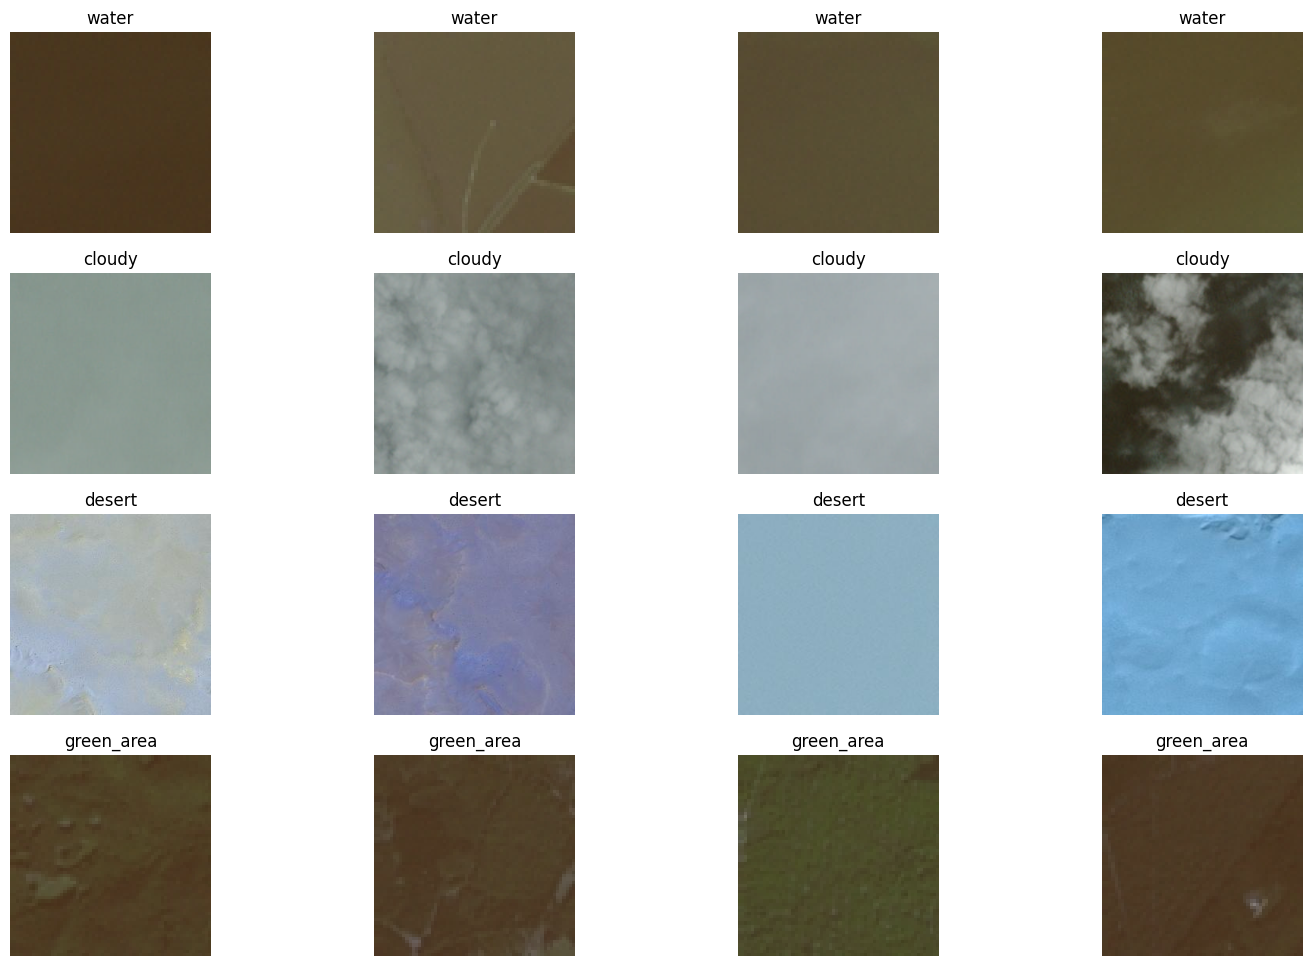

In [ ]:
import numpy as np
import os
import cv2
root="/content/data"
import matplotlib.pyplot as plt


fig,axes=plt.subplots(4,4,figsize=(18,12))
axes=axes.ravel()
idx=0
for path in os.listdir(root):
  fold_p=os.path.join(root,path)
  prev=idx
  for file_p in os.listdir(fold_p):
    img_p=os.path.join(fold_p,file_p)
    plt.subplot(4,4,idx+1)
    plt.imshow(cv2.imread(img_p))
    plt.axis("off")
    plt.title(path)

    print(img_p,idx)
    idx+=1
    if idx-prev==4:
      break
  if idx==16:
    break

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

ds_train,ds_val=image_dataset_from_directory(root,
                                    batch_size=32,
                                    image_size=(224,224),
                                    shuffle=True,
                                    seed=42,
                                   validation_split=0.4,
                                    subset="both",
                                    label_mode="categorical"

                                    )

Found 5631 files belonging to 4 classes.
Using 3379 files for training.
Using 2252 files for validation.


In [ ]:
print("Number of batches in training-dataset:",len(ds_train))
print("Number of batches in validation-dataset:",len(ds_val))

Number of batches in training-dataset: 106
Number of batches in validation-dataset: 71


In [ ]:
class_names=ds_train.class_names
print(class_names)

['cloudy', 'desert', 'green_area', 'water']


(32, 224, 224, 3)
(32, 4)


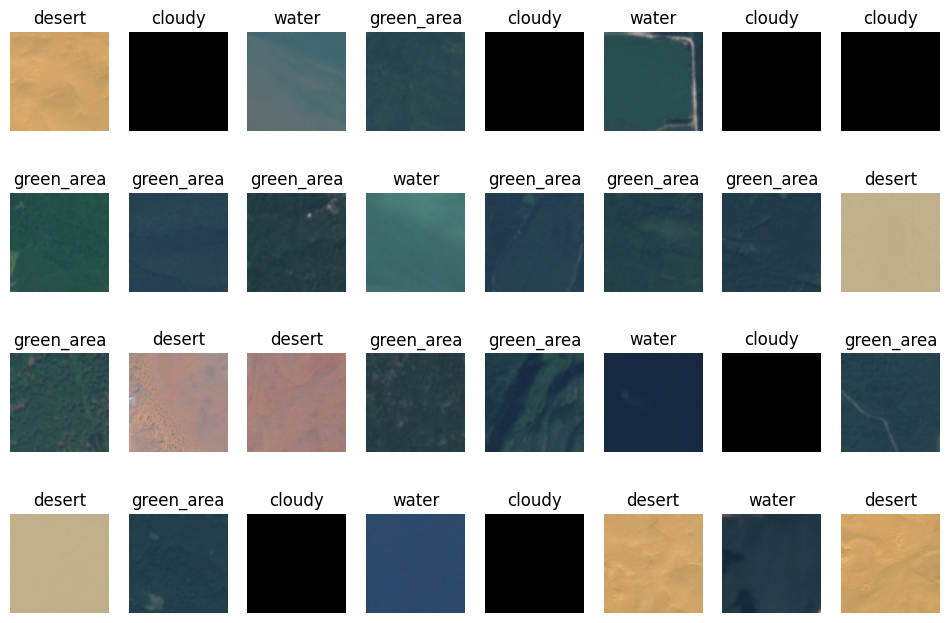

In [ ]:
plt.figure(figsize=(12,8))
for img,label in ds_train.take(1):
  print(img.shape)
  print(label.shape)
  for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[np.argmax(label[i])])

In [ ]:
import tensorflow as tf

In [ ]:
resize_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(224,224),
    tf.keras.layers.Rescaling(1./255)

])
augment=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomBrightness(factor=0.2)
])

def aug_lay(img,label):
  return augment(resize_rescale(img),training=True),label

def resize_rescale_lay(img,label):
  return resize_rescale(img),label

In [ ]:
ds_train_mp=ds_train.map(aug_lay,num_parallel_calls=tf.data.AUTOTUNE)
ds_val_mp=ds_val.map(aug_lay,num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.regularizers import l1, l2

In [ ]:
# prompt: construct a lenet model hving high accuracy

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3) ,activation="relu",input_shape=(224,224,3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3) ,activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(units=4,activation="softmax")
])
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy","precision","AUC"])


In [ ]:
model.save("model.h5")

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

early_stop=EarlyStopping(patience=10,verbose=1,monitor="val_accuracy",restore_best_weights=True)
model_checkpoint=ModelCheckpoint("model.keras",monitor="val_accuracy",verbose=1,save_best_only=True)
reduce_lr=ReduceLROnPlateau(monitor="val_accuracy",factor=0.3,patience=5,verbose=1)

In [ ]:
model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val,
    callbacks=[early_stop,model_checkpoint,reduce_lr],
    batch_size=32,
    verbose=1
)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.8475 - accuracy: 0.6753 - loss: 11.5279 - precision: 0.7090
Epoch 1: val_accuracy improved from -inf to 0.73091, saving model to model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 482s 5s/step - AUC: 0.8481 - accuracy: 0.6756 - loss: 11.4473 - precision: 0.7103 - val_AUC: 0.9493 - val_accuracy: 0.7309 - val_loss: 0.6715 - val_precision: 0.9941 - learning_rate: 0.0010
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.9530 - accuracy: 0.7458 - loss: 0.6092 - precision: 0.9889
Epoch 2: val_accuracy did not improve from 0.73091
106/106 ━━━━━━━━━━━━━━━━━━━━ 498s 5s/step - AUC: 0.9529 - accuracy: 0.7457 - loss: 0.6095 - precision: 0.9885 - val_AUC: 0.9363 - val_accuracy: 0.7167 - val_loss: 0.6846 - val_precision: 0.9443 - learning_rate: 0.0010
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.8654 - accuracy: 0.5900 - loss: 0.9661 - precision: 0.9481
Epoch 3: val_accuracy did not improve from 0.73091
106/106 ━━━━━━━━━━━━━━

In [ ]:
score=model.evaluate(ds_val)
score
print("accuracy :",score[1])
print("AUC :",score[0])
print("loss :",score[2])
print("precision:",score[3])

71/71 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - AUC: 0.9499 - accuracy: 0.7338 - loss: 0.6759 - precision: 0.9960
accuracy : 0.7309058904647827
AUC : 0.671506941318512
loss : 0.9941349029541016
precision: 0.9493103623390198


In [ ]:
pred=model.predict(ds_val)
prediction=np.argmax(pred,axis=1)
prediction

71/71 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step


array([2, 2, 2, ..., 2, 2, 0])

In [ ]:
len(prediction)%32

12

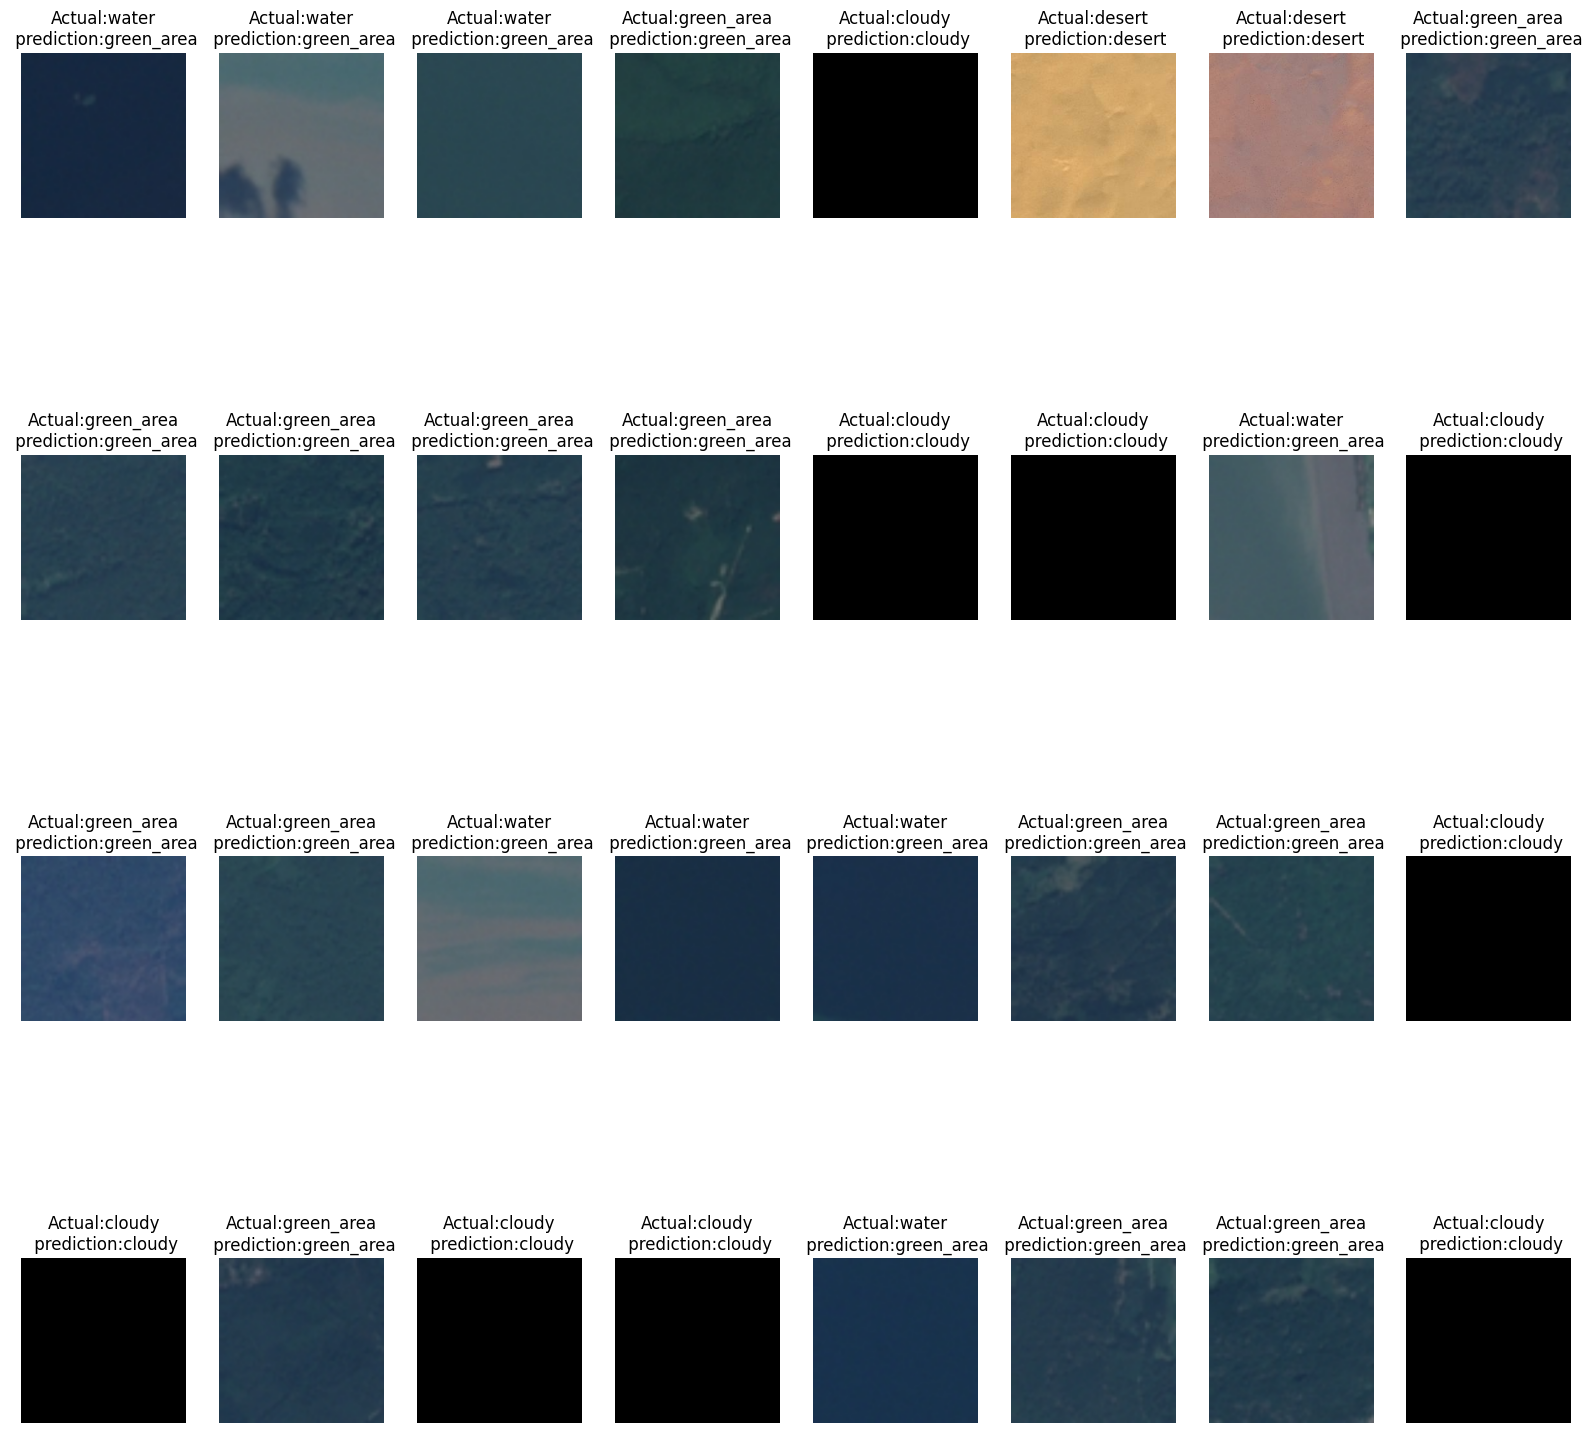

In [ ]:
len(prediction)
plt.figure(figsize=(20,20))
for img,label in ds_val:
  for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(f"Actual:{class_names[np.argmax(label[i])]}\n prediction:{class_names[prediction[i]]}")

  break